In [2]:
from fontTools.misc.arrayTools import pointInRect
## Run when initialise the code


from pandas import DataFrame

from shapely.ops import nearest_points

from geopandas import GeoDataFrame
from shapely.geometry import  MultiPolygon,MultiLineString, MultiPoint
from shapely.ops import linemerge, unary_union,split,substring
from shapely.strtree import STRtree
from shapely.geometry.base import BaseGeometry
from shapely.prepared import prep

import geopandas as gpd
from shapely.geometry import Point, LineString

import pandas as pd

import os
import requests
from tqdm import tqdm
from sklearn.cluster import DBSCAN

import numpy as np
import math
from math import log2

from itertools import groupby, combinations
from collections import defaultdict

import warnings
from dataclasses import dataclass
from typing import Set


import networkx as nx

warnings.filterwarnings(action='ignore')

pjr_loc = os.path.dirname(os.getcwd())
project_crs = 'epsg:3857'
place = 'Turin,Italy'
place_folder = f'{pjr_loc}/places'
os.makedirs(place_folder , exist_ok=True)
data_folder = f'{place_folder}/{place.replace(",","_")}'
os.makedirs(data_folder, exist_ok=True)
test_folder = f'{data_folder}/test'
os.makedirs(test_folder, exist_ok=True)

In [3]:

def get_bbox_from_nominatim(place_name):
    """
    Fetches the bounding box of a place using the Nominatim API.

    Parameters:
        place_name (str): The name of the place to search.

    Returns:
        tuple: (south, north, west, east) as floats.
    """
    url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": place_name,
        "format": "json",
        "limit": 1
    }
    headers = {
        "User-Agent": "GeoResearcher/1.0 (achituv@ariel.ac.il)"  # Update if needed
    }

    response = requests.get(url, params=params, headers=headers)
    response.raise_for_status()
    results = response.json()

    if not results:
        raise ValueError(f"No results found for place: {place_name}")

    bbox = results[0]["boundingbox"]
    return float(bbox[0]), float(bbox[1]), float(bbox[2]), float(bbox[3])

def download_osm_roads_bbox(place_name, highway_tags=None):
    """
    Downloads OpenStreetMap road data within the bounding box of a given place name.

    Parameters:
    ----------
    place_name : str
        Name of the place to retrieve the road data for. The function uses the Nominatim API
        to geocode this name into a bounding box.

    highway_tags : list of str, optional
        A list of OSM 'highway' tag values to filter the types of roads to download.
        If not provided, a default list including common road and path types is used:
        ['primary','footway','pedestrian','cycleway','path','secondary',
         'tertiary','unclassified','residential','service','living_street','steps']

    Returns:
    -------
    GeoDataFrame
        A GeoDataFrame containing the downloaded road features within the bounding box.
        Each feature includes its geometry (LineString), 'osmid' (OSM way ID), and other OSM tags.
        CRS is EPSG:4326.
    """
    if highway_tags is None:
        highway_tags = [
            'primary', 'footway', 'pedestrian', 'cycleway', 'path',
            'secondary', 'tertiary', 'unclassified', 'residential',
            'service', 'living_street', 'steps'
        ]

    # Get bounding box from place name
    south, north, west, east = get_bbox_from_nominatim(place_name)
    highway_filter = '|'.join(highway_tags)

    # Construct Overpass QL query
    overpass_url = "http://overpass-api.de/api/interpreter"
    query = f"""
    [out:json][timeout:180];
    (
      way["highway"~"{highway_filter}"]({south},{west},{north},{east});
    );
    out geom;
    """

    # Send query to Overpass API
    response = requests.get(overpass_url, params={'data': query})
    response.raise_for_status()
    data = response.json()

    # Convert results to GeoDataFrame
    roads = []
    for element in data['elements']:
        if element['type'] == 'way' and 'geometry' in element:
            coords = [(p['lon'], p['lat']) for p in element['geometry']]
            if len(coords) >= 2:
                geom = LineString(coords)
                tags = element.get('tags', {})
                tags['geometry'] = geom
                tags['osmid'] = element['id']
                roads.append(tags)

    gdf = gpd.GeoDataFrame(roads, geometry='geometry', crs='EPSG:4326')
    return gdf


def merge_lines_by_attributes(gdf, attrs=['name', 'highway']):
    """
    Efficiently merges line geometries in a GeoDataFrame by grouping them based on specified attributes.

    Parameters:
        gdf (GeoDataFrame): Input GeoDataFrame with line geometries.
        attrs (list of str): List of attribute names to group by.

    Returns:
        GeoDataFrame: New GeoDataFrame with merged_inter LineStrings or MultiLineStrings split into parts.
    """
    records = []
    grouped = gdf.groupby(attrs, sort=False)

    for key, group in tqdm(grouped, total=len(grouped), desc="Merging lines"):
        lines = list(group.geometry)

        if len(lines) == 1:
            records.append({**dict(zip(attrs, key)), 'geometry': lines[0]})
            continue

        merged = linemerge(MultiLineString(lines))

        if isinstance(merged, LineString):
            records.append({**dict(zip(attrs, key)), 'geometry': merged})
        elif isinstance(merged, MultiLineString):
            for part in merged.geoms:
                records.append({**dict(zip(attrs, key)), 'geometry': part})

    return gpd.GeoDataFrame(records, crs=gdf.crs)

def startswith(line, sub):
    return tuple(line.coords[:len(sub.coords)]) == tuple(sub.coords)

def endswith(line, sub):
    return tuple(line.coords[-len(sub.coords):]) == tuple(sub.coords)



In [6]:
gdf_osm = download_osm_roads_bbox(place)[['highway','name','osmid','junction','geometry']].to_crs(project_crs )
gdf_osm.reset_index().to_file(f"{data_folder}/osm_data.shp")

In [130]:



def trim_duplicate_line(
    inter_inter,
    merged_inter,
    tree_buffer_inter,
    edges_buffer_inter,
    idx1,
    idx2,
    buffer_distance=5
):
    """
    Lighter version:
    - Avoids gpd.overlay inside the loop
    - Uses intersection area directly on buffered overlap
    """
    subset = merged_inter.loc[[idx1, idx2]]

    # Case 1: Same name -> pick one to trim by start/end position
    if subset.loc[idx1, 'name'] == subset.loc[idx2, 'name']:
        line_to_trim_row = subset.loc[[idx2]]
        line_to_trim = line_to_trim_row['geometry'].iloc[0]

        if not (startswith(line_to_trim, inter_inter) or endswith(line_to_trim, inter_inter)):
            line_to_trim_row = subset.loc[[idx1]]
            line_to_trim = line_to_trim_row['geometry'].iloc[0]

    else:
        # Case 2: Different names -> pick the one with *smaller* overlap area
        inter_buffer = inter_inter.buffer(buffer_distance)

        # STRtree query for buffered intersection
        candidates_idx = tree_buffer_inter.query(inter_buffer)
        if len(candidates_idx) == 0:
            # fallback: arbitrarily choose idx2 to trim
            line_to_trim_row = subset.loc[[idx2]]
            line_to_trim = line_to_trim_row['geometry'].iloc[0]
        else:
            gdf_target = edges_buffer_inter.iloc[candidates_idx]

            best_name = None
            best_area = -1.0

            # Find which geometry overlaps the buffer the most
            for _, row in gdf_target.iterrows():
                area = inter_buffer.intersection(row.geometry).area
                if area > best_area:
                    best_area = area
                    best_name = row['name']

            # Trim the other line (the one that does NOT have the largest overlap)
            line_to_trim_row = subset[subset['name'] != best_name]
            if line_to_trim_row.empty:
                # fallback – if logic fails, just trim idx2
                line_to_trim_row = subset.loc[[idx2]]

            line_to_trim = line_to_trim_row['geometry'].iloc[0]

    # Step: Trim based on where the overlap is
    if startswith(line_to_trim, inter_inter):
        trimmed_line = substring(line_to_trim, inter_inter.length, line_to_trim.length)
    else:
        trimmed_line = substring(line_to_trim, 0, line_to_trim.length - inter_inter.length)

    return trimmed_line, int(line_to_trim_row.index[0])


def split_lines_by_intersections_fast(gdf, intersections, buffer_eps=0.0001):
    """
    Splits line geometries at intersection points using a buffered boundary union.

    Parameters:
        gdf (GeoDataFrame): Input GeoDataFrame containing line geometries.
        intersections (list of Point): Points where lines should be split.
        buffer_eps (float): Buffer radius to create boundaries around each intersection point for splitting.

    Returns:
        GeoDataFrame: New GeoDataFrame with split line segments, preserving 'name' and 'highway' attributes.
    """
    if not intersections:
        return gdf.copy()

    # Build splitting geometry
    splitters = unary_union([pt.buffer(buffer_eps).boundary for pt in intersections])
    prepared_splitters = prep(splitters)

    records = []
    for row in gdf.itertuples(index=False):
        geom = row.geometry

        if prepared_splitters.intersects(geom):
            try:
                split_parts = split(geom, splitters)
                for part in split_parts.geoms:
                    if part.length > 0:
                        records.append({
                            'name': getattr(row, 'name', None),
                            'highway': getattr(row, 'highway', None),
                            'geometry': part
                        })
            except Exception:
                # Fallback in case of split failure
                records.append({
                    'name': getattr(row, 'name', None),
                    'highway': getattr(row, 'highway', None),
                    'geometry': geom
                })
        else:
            records.append({
                'name': getattr(row, 'name', None),
                'highway': getattr(row, 'highway', None),
                'geometry': geom
            })

    temp_geo = gpd.GeoDataFrame(records, crs=gdf.crs)
    temp_geo =temp_geo[temp_geo.length >1e-4]
#     temp_geo['geometry'] = temp_geo['geometry'].apply(
#     lambda geom: LineString([(round(x), round(y)) for x, y in geom.coords])
# )
    return temp_geo

def extract_internal_intersections_spatial_index_fast(
    merged,
    edges_buffer_in,
    tree_for_buffer,
    buffer_eps=0.0001,
    do_trim=True
):
    """
    Faster variant of extract_internal_intersections_spatial_index.

    Parameters
    ----------
    merged : GeoDataFrame
        Lines (e.g. road segments).
    edges_buffer_in : GeoDataFrame
        Buffered edges used inside trim_duplicate_line.
    tree_for_buffer : STRtree
        STRtree built from edges_buffer.geometry.
    buffer_eps : float
        Optional small buffer for near-miss intersections.
    do_trim : bool
        If False, skip trimming and only collect intersection points.

    Returns
    -------
    (points_list, merged_updated)
    """

    # Stable arrays: positions -> geometry, positions -> original index
    geoms = merged.geometry.to_list()
    idx_array = merged.index.to_numpy()
    tree = STRtree(geoms)

    # Collectors
    raw_points = []        # all intersection points
    seen_pairs = set()     # (min_idx, max_idx)
    to_drop = set()        # indices to drop after loop
    to_trim = dict()       # idx -> new geometry to assign

    for pos, geom in enumerate(tqdm(geoms, total=len(geoms), desc="Extracting intersections")):
        idx = idx_array[pos]

        # If this index is already marked for drop, skip
        if idx in to_drop:
            continue

        # Query spatial index for candidates
        cand_positions = tree.query(geom)
        # (if using shapely 2: tree.query(geom, predicate="intersects"))

        for c_pos in cand_positions:
            if c_pos == pos:
                continue

            jdx = idx_array[c_pos]
            if jdx in to_drop or jdx == idx:
                continue

            pair = (min(idx, jdx), max(idx, jdx))
            if pair in seen_pairs:
                continue
            seen_pairs.add(pair)

            other = geoms[c_pos]

            # If there is no intersection extend the lines by meters
            if not geom.intersects(other):
                if buffer_eps is not None and buffer_eps > 0:
                    extended = extend_lines_fast([other,geom], 1)
                    if not extended[0].intersects(extended[1]):
                        continue
                    inter_pnt = extended[0].intersection(extended[1])
                else:
                    continue
            else:
                inter_pnt = geom.intersection(other)
            if inter_pnt.is_empty:
                continue

            gtype = inter_pnt.geom_type

            # Point intersections
            if gtype == "Point":
                raw_points.append(inter_pnt)

            # Line intersections (overlaps)
            elif gtype == "LineString":
                # full overlaps → mark one to drop
                if geom.equals(inter_pnt):
                    to_drop.add(idx)
                    break  # no need to continue with this geom
                if other.equals(inter_pnt):
                    to_drop.add(jdx)
                    continue

                if do_trim:
                    trimmed, id_trim = trim_duplicate_line(
                        inter_inter=inter_pnt,
                        merged_inter=merged,
                        tree_buffer_inter=tree_for_buffer,
                        edges_buffer_inter=edges_buffer_in,
                        idx1=idx,
                        idx2=jdx,
                        buffer_distance=5
                    )
                    # store trim result
                    to_trim[id_trim] = trimmed

                    # recompute a point intersection with trimmed geometry
                    if id_trim == idx:
                        new_geom = trimmed
                        inter2 = new_geom.intersection(other)
                    else:
                        new_other = trimmed
                        inter2 = geom.intersection(new_other)

                    if not inter2.is_empty:
                        if inter2.geom_type == "Point":
                            raw_points.append(inter2)
                        elif inter2.geom_type.startswith("Multi") or inter2.geom_type == "GeometryCollection":
                            raw_points.extend(
                                g for g in inter2.geoms if g.geom_type == "Point"
                            )

            # Multi/GeometryCollection → take only point parts
            elif gtype.startswith("Multi") or gtype == "GeometryCollection":
                raw_points.extend(
                    g for g in inter_pnt.geoms if g.geom_type == "Point"
                )

    # ---- Apply drops and trims ----
    merged_updated = merged.drop(index=list(to_drop)).copy()

    for id_trim, new_geom in to_trim.items():
        if id_trim in merged_updated.index:
            merged_updated.at[id_trim, 'geometry'] = new_geom

    # ---- Deduplicate points by rounded coordinates ----
    unique_points = []
    seen_coords = set()

    for pt in raw_points:
        key = (round(pt.x, 6), round(pt.y, 6))
        if key not in seen_coords:
            seen_coords.add(key)
            unique_points.append(pt)

    return unique_points, merged_updated


def fix_line_topology(gdf_edges_0, buffer_dist=1):
    """
    Cleans and fixes line topology by:
      1. Buffering edges for spatial indexing
      2. Merging lines by 'name' and 'highway'
      3. Extracting internal intersections via spatial index
      4. Splitting merged_inter lines at intersection points

    Parameters
    ----------
    gdf_edges : GeoDataFrame
        Input line layer with at least 'name' and 'highway' attributes.
    buffer_dist : float, default=1
        Buffer distance (in CRS units) used for spatial index creation.

    Returns
    -------
    fix_topology : GeoDataFrame
        Resulting GeoDataFrame of split line segments.
    internal_points : GeoDataFrame
        Points representing internal intersections.
    """
    gdf_edges_internal= gdf_edges_0.copy()
    # Step 1: Prepare buffered layer for efficient spatial indexing
    edges_buffer = gdf_edges_internal.copy()
    edges_buffer['geometry'] = gdf_edges_internal.geometry.buffer(buffer_dist, cap_style=2)
    tree_buffer = STRtree(edges_buffer.geometry)

    # Step 2: Merge lines by 'name' and 'highway'
    gdf_merge = merge_lines_by_attributes(gdf_edges_internal, attrs=['name', 'highway'])
    gdf_merge = gdf_merge[gdf_merge.geometry.notnull()]

    # Step 3: Extract internal intersections
    internal_points_inter, merged = extract_internal_intersections_spatial_index_fast(
        gdf_merge, edges_buffer, tree_buffer
    )

    # Step 4: Split merged_inter lines at intersections
    fix_topology_fi = split_lines_by_intersections_fast(merged, internal_points_inter)

    return fix_topology_fi, internal_points_inter

def snap_endpoints(gdf: gpd.GeoDataFrame, threshold: float = 1.0):
    """
    Snap close endpoints using DBSCAN clustering.

    Parameters:
        gdf (GeoDataFrame): LineString geometries.
        threshold (float): Distance threshold for snapping points.

    Returns:
        GeoDataFrame: Updated lines with snapped endpoints.
    """

    # Step 1: Create points_data dataframe
    data = []
    for idx, geom in gdf.geometry.items():
        data.append({'line_idx': idx, 'point': Point(geom.coords[0]), 'loc': 0})
        data.append({'line_idx': idx, 'point': Point(geom.coords[-1]), 'loc': -1})

    points_data = pd.DataFrame(data)

    # Step 2: Run DBSCAN on point coordinates
    coords = np.array([[p.x, p.y] for p in points_data['point']])
    clustering = DBSCAN(eps=threshold, min_samples=2).fit(coords)
    points_data['cluster'] = clustering.labels_

    # Step 3: Filter out noise
    points_data = points_data[points_data['cluster']>-1].copy()

    # Step 4: Choose representative point for each cluster
    cluster_representatives = points_data.groupby('cluster')['point'].apply(lambda x: x.iloc[-1]).to_dict()

    # Step 5: Modify line endpoints
    gdf = gdf.copy()
    for cluster, group in points_data.groupby('cluster'):
        rep = cluster_representatives[cluster]
        for _, row in group.iterrows():
            idx = row['line_idx']
            geom = gdf.at[idx, 'geometry']
            coords = list(geom.coords)
            if row['loc'] == 0:
                coords[0] = (rep.x, rep.y)
            else:
                coords[-1] = (rep.x, rep.y)
            gdf.at[idx, 'geometry'] = LineString(coords)

    return gdf

def circular_distance(angle1, angle2):
    """Compute minimum circular angle difference between two angles."""
    diff = np.abs(angle1 - angle2) % 180
    return np.minimum(diff, 180 - diff)

def calculate_bearing(line):
    """
    Calculate the bearing (azimuth) in degrees from the start to the end of a LineString.

    Parameters:
    -----------
    line : shapely.geometry.LineString
        The input LineString geometry.

    Returns:
    --------
    float
        Bearing in degrees (0° to 360°), or NaN if the geometry is invalid or too short.
    """
    if not line or line.is_empty or len(line.coords) < 2:
        return np.nan

    x1, y1 = line.coords[0]
    x2, y2 = line.coords[-1]
    angle = np.degrees(np.arctan2(x2 - x1, y2 - y1))
    return (angle + 360) % 360
def remove_unconnected_streets(df_connected, str_name='name_left', con_str_name='name_right'):
    """
    Remove streets from a GeoDataFrame that are not connected to any other streets.

    Parameters:
    df_connected (GeoDataFrame): The input GeoDataFrame containing street data.
    str_name (str): The column name for the street name in the first dataset.
    con_str_name (str): The column name for the connected street name in the second dataset.

    Returns:
    GeoDataFrame: A new GeoDataFrame with unconnected streets removed.
    """
    df_analysis = df_connected.copy()
    s_join_analysis = gpd.sjoin(df_analysis, df_connected)
    s_join_analysis2 = s_join_analysis[s_join_analysis[str_name] != s_join_analysis[con_str_name]]
    not_connected = set(df_connected['name']) - set(s_join_analysis2.reset_index()[str_name])
    df_pro_filtered = df_connected[~df_connected['name'].isin(not_connected)]
    return df_pro_filtered

def preprocess_and_assign_roundabout_names(
    gdf_roads_0,
    data_folder,
    buffer_distance=1.5,
):
    """
    Processes road and roundabout geometries:
    - Removes unconnected streets
    - Merges roundabout segments
    - Identifies streets connected to roundabouts
    - Assigns names to unnamed roads based on connections and angle proximity

    Parameters:
        gdf_roads_0 (GeoDataFrame): Raw road data (must have 'junction', 'geometry', 'name', 'angle')
        data_folder (str): Folder path to save roundabout shapefile
        buffer_distance (float): Distance to consider road as connected to roundabout
        save_roundabout_shp (bool): Whether to export roundabout geometries as SHP

    Returns:
        gdf_roundabout (GeoDataFrame): Merged roundabout geometries
        gdf_roads (GeoDataFrame): Updated roads with names assigned
    """

    # Step 0: Clean roads and separate roundabouts
    gdf_roads = remove_unconnected_streets(gdf_roads_0.copy())
    roundabout_types = ['roundabout', 'circular', 'mini_roundabout']
    gdf_roundabouts = gdf_roads[gdf_roads['junction'].isin(roundabout_types)]
    gdf_roads = gdf_roads[~gdf_roads['junction'].isin(roundabout_types)]

    # Step 1: Merge roundabout segments
    merged_geom = unary_union(gdf_roundabouts.geometry)
    connected_lines = linemerge(merged_geom)

    if isinstance(connected_lines, LineString):
        lines_list = [connected_lines]
    elif isinstance(connected_lines, MultiLineString):
        lines_list = list(connected_lines.geoms)
    else:
        lines_list = []

    gdf_roundabout = gpd.GeoDataFrame(geometry=lines_list, crs=gdf_roundabouts.crs)


    gdf_roundabout.to_file(f'{data_folder}/roundabout.shp')

    # Step 2: Buffer roundabouts
    roundabout_buffer = gdf_roundabout.copy()
    roundabout_buffer['geometry'] = roundabout_buffer.geometry.buffer(buffer_distance)

    # Step 3: Spatial join — find which roads touch roundabouts
    intersections = gpd.sjoin(
        gdf_roads,
        roundabout_buffer,
        how='inner',
        predicate='intersects'
    )

    # Build a spatial lookup dictionary of roads by node
    node_to_osmid = {}
    for idx, row in gdf_roads.iterrows():
        geom = row.geometry
        start, end = tuple(geom.coords[0]), tuple(geom.coords[-1])
        for pt in (start, end):
            node_to_osmid.setdefault(pt, set()).add(idx)

    # Step 4: Assign names based on connected roads
    for idx, row in intersections.iterrows():

        name = row['name']
        if pd.notna(name) and name.strip() != '':
            continue  # Already has name

        geom = row.geometry
        start, end = tuple(geom.coords[0]), tuple(geom.coords[-1])

        # Find neighboring road indices
        neighbors = node_to_osmid.get(start, set()).union(node_to_osmid.get(end, set()))
        neighbors.discard(idx)  # remove self

        # Get all named neighbors (name, angle, idx)
        named_neighbors = []
        for n_idx in neighbors:
            n_row = gdf_roads.loc[n_idx]
            n_name = n_row['name']
            if pd.notna(n_name) and n_name.strip() != '':
                named_neighbors.append((n_name.strip(), n_row.get('angle', 999), n_idx))

        # If no named neighbors, skip
        if not named_neighbors:
            continue
        # If one unique name, assign it
        unique_names = list({n[0] for n in named_neighbors})
        if len(unique_names) == 1:
            gdf_roads.at[idx, 'name'] = unique_names[0]
        else:
            # More than one candidate — choose by closest angle
            angle_diffs = {}
            for name, angle, _ in named_neighbors:
                if name not in angle_diffs:
                    angle_diffs[name] = circular_distance(angle, row['angle'])

            # Pick the name with the smallest angle difference
            best_name = min(angle_diffs.items(), key=lambda x: x[1])[0]
            gdf_roads.at[idx, 'name'] = best_name

    return gdf_roundabout, gdf_roads


In [22]:
### TEst AREa

### TEst AREa AND

In [9]:
gdf_roads_0= gdf_osm.copy()
gdf_roads_0['bearing'] = gdf_roads_0['geometry'].apply(calculate_bearing)
gdf_roads_0['angle'] = gdf_roads_0['bearing'].apply(lambda x: x if x < 180 else x - 180)
# Step 0: Preprocess roads and separate roundabouts
gdf_roundabout,gdf_edges = preprocess_and_assign_roundabout_names(gdf_roads_0,data_folder)

# Step 1: Clean and filter edge attributes
gdf_edges = gdf_edges[
    ~gdf_edges['highway'].str.contains('link', case=False, na=False) &
    gdf_edges['name'].notna() &
    (gdf_edges['name'] != '')
]

# Step 2: Buffer for spatial indexing
fix_topology, internal_points = fix_line_topology(gdf_edges)

# Step 6: Snap endpoints and compute attributes
first_results = snap_endpoints(fix_topology)
first_results['bearing'] = first_results['geometry'].apply(calculate_bearing)
first_results['angle'] = first_results['bearing'].apply(lambda x: x if x < 180 else x - 180)
first_results['length'] = first_results.length

# Step 7: Rebuild spatial index for final results
# edges_buffer_inter = first_results.copy()
# edges_buffer_inter['geometry'] = first_results.geometry.buffer(1)
# tree_buffer_inter = STRtree(edges_buffer_inter.geometry)

# Step 8: Export results
first_results.reset_index().to_file(f'{data_folder}/edges.shp')
gdf_roundabout.reset_index().to_file(f'{data_folder}/roundabout_edges.shp')

Extracting intersections: 100%|██████████| 9381/9381 [00:06<00:00, 1545.99it/s]


In [ ]:
# Test Area


In [5]:

# Test Area - END


In [10]:
def load_gdf(path):
    return gpd.read_file(path).set_index("index").rename_axis(None)

In [29]:
first_results = load_gdf(f"{data_folder}/edges.shp")
gdf_roundabout = load_gdf(f"{data_folder}/roundabout_edges.shp")

In [11]:

def build_street_connection_dict(gdf_streets):
    """
    Build a dictionary of street-to-street connections via unique intersection points.

    Parameters:
        gdf_streets (GeoDataFrame): A GeoDataFrame containing street segments, with a 'name' column.

    Returns:
        connection_dict (dict): A dictionary where each key is a tuple of two street names (str, str),
                                and each value is a list of unique shapely Points where the streets intersect.
    """
    # Ensure clean index
    gdf = gdf_streets.reset_index(drop=True)

    # Step 1: Perform spatial join to find intersecting features
    joined = gpd.sjoin(gdf, gdf, how='inner', predicate='intersects')
    joined = joined[joined.index != joined['index_right']]  # Remove self-intersections

    # Step 2: Initialize output containers
    connection_dict = defaultdict(list)
    seen_edges = set()

    # Step 3: Process each intersecting pair
    for idx, row in tqdm(joined.iterrows(), total=len(joined)):
        idx2 = row['index_right']
        name1 = row['name_left']
        name2 = row['name_right']

        # Skip connections within the same street
        if name1 == name2:
            continue

        pair_key = tuple(sorted((name1, name2)))
        geom1 = row.geometry
        geom2 = gdf.loc[idx2].geometry
        intersection = geom1.intersection(geom2)

        # Skip if no actual intersection
        if intersection.is_empty:
            continue

        # Normalize intersection geometry into list of points
        if intersection.geom_type == 'Point':
            inter_points = [intersection]
        elif intersection.geom_type == 'MultiPoint':
            inter_points = list(intersection.geoms)
        else:
            continue  # Ignore non-point intersections

        # Step 4: Store only new intersection points
        existing_coords = {tuple(pt.coords)[0] for pt in connection_dict[pair_key]}
        new_points = [pt for pt in inter_points if tuple(pt.coords)[0] not in existing_coords]

        if new_points:
            connection_dict[pair_key].extend(new_points)
            seen_edges.add(pair_key)

    return connection_dict
conn_dict = build_street_connection_dict(first_results)

100%|██████████| 109990/109990 [00:29<00:00, 3733.75it/s]


In [12]:

# ------------------------------------------------------------
# STEP 2: Create a buffer around merged_inter roundabouts and find intersecting street edges
# ------------------------------------------------------------
# Buffer each merged_inter roundabout line (e.g., 5 meters)
roundabout_buffer = gdf_roundabout.copy()
roundabout_buffer['geometry'] = roundabout_buffer.geometry.buffer(5)

# Perform spatial join: find street edges that intersect the roundabout buffer
intersections = gpd.sjoin(first_results, roundabout_buffer, how='inner', predicate='intersects')

# ------------------------------------------------------------
# STEP 3: Build dictionary mapping roundabout index to connected street names
# ------------------------------------------------------------
roundabout_to_streets = defaultdict(set)
# Ensure every roundabout is included in the dictionary, even if not connected
for ridx in roundabout_buffer.index:
    roundabout_to_streets.setdefault(ridx, set())

for _, row in intersections.iterrows():
    roundabout_idx = row['index_right']  # index of the matched roundabout in gdf_merged
    street_name = row['name']
    roundabout_to_streets[roundabout_idx].add(street_name)


# ------------------------------------------------------------
# STEP 4: Calculate center point for each roundabout polygon buffer
# - Buffer again with clean style, then extract centroid
# ------------------------------------------------------------
# Buffer with styling for rounded shapes, then get centroids
roundabout_centers = gdf_roundabout['geometry'].buffer(distance=1, cap_style=1, join_style=1).centroid

# Compute distance from centroid to the boundary of the buffer
distances = [
    centroid.distance(line)
    for centroid, line in zip(roundabout_centers, gdf_roundabout['geometry'])
]

# Save as GeoDataFrame
gdf_roundabouts = gpd.GeoDataFrame(geometry=roundabout_centers, crs=gdf_roundabout.crs)
# Compute distance from centroid to buffer boundary
gdf_roundabouts['dist'] = distances
# Creata buffer of "dist" which will be used later in the code
gdf_roundabouts['geometry_buffer'] = gdf_roundabouts.apply(lambda row: row.geometry.buffer(row['dist']*2), axis=1)
gdf_roundabouts.drop(columns=['geometry_buffer']).reset_index().to_file(f'{data_folder}/center_roundabout.shp')



In [ ]:
# Test area
# Test area - END

In [13]:

# This code performs the main part of the simplification
# --- Helper Functions ---

def check_parallelism(to_translate: GeoDataFrame) -> bool:
    """
    Checks whether a group of line segments contain any parallel segments
    by offsetting each line and checking buffer intersections.
    """
    my_buffer = to_translate['geometry'].buffer(cap_style=2, distance=30, join_style=3)
    to_translate['geometry_right'] = to_translate['geometry'].apply(lambda x: x.parallel_offset(35, 'right'))
    to_translate['geometry_left'] = to_translate['geometry'].apply(lambda x: x.parallel_offset(35, 'left'))

    def is_parallel(my_s_join: GeoDataFrame, the_buffer, geo_field: str):
        my_s_join['geometry'] = my_s_join[geo_field]
        sjoin = my_s_join.sjoin(GeoDataFrame(geometry=the_buffer, crs=project_crs), how='inner')
        sjoin = sjoin[sjoin.index != sjoin['index_right']]
        for _, row in sjoin.iterrows():
            overlay = gpd.overlay(
                GeoDataFrame([row], crs=project_crs),
                GeoDataFrame(geometry=[the_buffer[row['index_right']]], crs=project_crs),
                how='intersection')
            if (overlay.length / row.geometry.length).iloc[0] * 100 > 10:
                return True
        return False

    return is_parallel(to_translate, my_buffer, 'geometry_right') or is_parallel(to_translate, my_buffer, 'geometry_left')


def add_more_pnts_to_new_lines(pnt_f, pnt_l, line_pnts, lngth_chck, test_poly):
    """
    Recursively add points along a line if they're more than 10m from existing road segments.
    """
    dist = pnt_f.distance(pnt_l)
    x0, y0 = pnt_f.x, pnt_f.y
    bearing = math.atan2(pnt_l.x - x0, pnt_l.y - y0)
    if bearing < 0:
        bearing += 2 * math.pi
    loops = int(dist / lngth_chck)

    for step in range(1, loops):
        x_new = x0 + lngth_chck * step * math.sin(bearing)
        y_new = y0 + lngth_chck * step * math.cos(bearing)
        new_point = Point(x_new, y_new)
        nearest = GeoDataFrame(geometry=[new_point], crs=project_crs).sjoin_nearest(test_poly, distance_col='dis').iloc[0]
        if nearest['dis'] > 10:
            line = data.loc[nearest['index_right']]['geometry']
            projected = line.interpolate(line.project(new_point))
            if projected.distance(pnt_f) < 10:
                continue
            line_pnts.append(projected)
            return add_more_pnts_to_new_lines(projected, pnt_l, line_pnts, lngth_chck, test_poly)
    return line_pnts

def create_center_line(one_poly):
    """
    Construct a center line through a polygon by identifying its farthest endpoints
    and interpolating new points as needed based on angular continuity.
    """
    lines = data.sjoin(GeoDataFrame(geometry=[one_poly], crs=project_crs)).drop(columns='index_right')
    if lines.empty:
        # # Because of how the buffers were created, some polygons might not intersect with the original lines
        return False
    endpoints = []
    lines['geometry'].apply(lambda line: endpoints.extend([Point(line.coords[0]), Point(line.coords[-1])]))
    combos = list(combinations(endpoints, 2))

    df = DataFrame({
        'point_1': [a for a, _ in combos],
        'point_2': [b for _, b in combos],
    })
    df['dist'] = df.apply(lambda x: x['point_1'].distance(x['point_2']), axis=1)
    dx = df['point_2'].apply(lambda p: p.x) - df['point_1'].apply(lambda p: p.x)
    dy = df['point_2'].apply(lambda p: p.y) - df['point_1'].apply(lambda p: p.y)
    df['angle'] = np.degrees(np.arctan2(dy, dx)) % 180
    avg_angle = lines['angle'].mean()
    df['ratio'] = df['dist'] / df['dist'].max() + 0.5 * np.abs(df['angle'] - avg_angle) / np.abs(df['angle'] - avg_angle).max()

    pnt_f, pnt_l = df.sort_values(by='ratio', ascending=False).iloc[0][['point_1', 'point_2']]
    angle_range = lines['angle'].max() - lines['angle'].min()


    step = 8.5 if angle_range > 100 else 75 - log2(angle_range) * 10 if angle_range > 1 else 75
    new_line_pts = add_more_pnts_to_new_lines(pnt_f, pnt_l, [pnt_f], step, lines)
    new_line_pts.append(pnt_l)
    return new_line_pts

def update_df_with_center_line(new_line,highway,temp_name,is_simplified=0, group_name=-1):
    """Append a new line feature to the output dictionary."""
    dic_final['name'].append(temp_name)
    dic_final['geometry'].append(new_line)
    dic_final['highway'].append(highway)
    dic_final['group'].append(group_name)
    dic_final['is_simplified'].append(is_simplified)
def extend_lines_fast(lines, ext):
    """
    Vector-ish: iterate over the ndarray of shapely LineStrings (no pandas apply).
    Extends each line by `ext` at both ends along the first/last segment directions.
    Returns a Python list of LineStrings (fast to build, then wrap as GeoSeries).
    """
    out = []
    append = out.append  # local binding is a tiny speed win
    for line in lines:
        # guard: must be a LineString with >= 2 vertices

        coords = line.coords

        # start segment direction
        x0, y0 = coords[0][:2]
        x1, y1 = coords[1][:2]
        vx0, vy0 = x1 - x0, y1 - y0
        n0 = math.hypot(vx0, vy0)
        if not n0:
            append(line); continue
        sx, sy = x0 - ext * vx0 / n0, y0 - ext * vy0 / n0

        # end segment direction
        xn_1, yn_1 = coords[-2][:2]
        xn, yn     = coords[-1][:2]
        vxn, vyn   = xn - xn_1, yn - yn_1
        nn = math.hypot(vxn, vyn)
        if not nn:
            append(line); continue
        ex, ey = xn + ext * vxn / nn, yn + ext * vyn / nn

        # build once; reuse existing coords object (no list comprehensions)
        new_coords = [(sx, sy)]
        new_coords.extend((xy[0], xy[1]) for xy in coords)
        new_coords.append((ex, ey))
        append(LineString(new_coords))
    return out

# ---- usage on a GeoDataFrame of lines ----
def buffered_with_short_caps(gdf_lines: gpd.GeoDataFrame,
                             ext_m=5.0,
                             side_buffer_m=35.0,
                             ) -> gpd.GeoDataFrame:
    """
    Extends each line by `ext_m`, then buffers by `side_buffer_m` with flat caps.
    If CRS is geographic, supply a metric EPSG (e.g., 3857/2039) for correct meters.
    """
    gdfp = gdf_lines


    # 1) extend lines (fast)
    extended = extend_lines_fast(gdfp.geometry.values, ext_m)

    # 2) buffer with flat caps (vectorized in shapely 2 / geopandas)
    buffers = gpd.GeoSeries(extended, crs=gdfp.crs).buffer(side_buffer_m, cap_style=2)

    # 3) wrap as GeoDataFrame
    return gpd.GeoDataFrame(geometry=buffers, crs=gdfp.crs)

def angular_distance(a, b, period=180):
    """
    Smallest circular angular distance between a and b (degrees).
    period=180 assumes undirected line orientation (0~180).
    Use period=360 if direction matters.
    """
    diff = abs((a - b) % period)
    return min(diff, period - diff)

def reassign_small_groups(
    gdf: gpd.GeoDataFrame,
    length_threshold: float = 150.0,
    max_group_size: int = 3,
    angle_col: str = "angle",
    group_col: str = "group",
    period: int = 180,
):
    """
    Iteratively:
      1) consider groups with size <= max_group_size and group != exclude_group
      2) if ANY line in that group has length > length_threshold -> keep (continue)
      3) else merge that group into another group (not exclude_group) whose average angle
         is closest to this group's average angle
      4) restart, because groups changed size

    Returns a modified copy of the GeoDataFrame.
    """
    gdf = gdf.copy()
    gdf['_len'] = gdf.length


    changed = True
    while changed:
        changed = False

        # Sizes of current groups
        sizes = gdf.groupby(group_col).size()

        # Candidate groups to check (<= max size and not excluded)
        candidates = [gid for gid, sz in sizes.items() if  sz <= max_group_size]

        if not candidates:
            break

        # Precompute average angles per group (over *all* groups)
        avg_angles = gdf.groupby(group_col)[angle_col].mean().to_dict()

        for gid in candidates:
            # Current group's rows
            mask = gdf[group_col] == gid
            grp = gdf[mask]

            # If any line is longer than the threshold – do nothing for this group
            if (grp["_len"] > length_threshold).any():
                continue

            # Compute the average angle of the current group
            this_avg = avg_angles.get(gid, None)
            if this_avg is None or np.isnan(this_avg):
                continue

            # Build a list of target groups (not itself, not excluded)
            possible_targets = [tg for tg in avg_angles.keys() if tg != gid ]
            if not possible_targets:
                continue

            # Find the target with minimum angular distance
            best_tg = None
            best_dist = float("inf")
            for tg in possible_targets:
                dist = angular_distance(this_avg, avg_angles[tg], period=period)
                if dist < best_dist:
                    best_dist = dist
                    best_tg = tg

            if best_tg is None:
                continue

            # Reassign this group's members to the best target group
            gdf.loc[mask, group_col] = best_tg
            # Recompute cached values for the next loop iteration
            changed = True
            break  # restart entire while-loop after any change

    # Clean up helper column
    gdf.drop(columns=["_len"], inplace=True, errors="ignore")
    return gdf
def pick_highway_by_length(df):
    if df["highway"].nunique() == 1:
        return df["highway"].iloc[0]
    return (
        df.assign(length=df.geometry.length)
          .groupby("highway")["length"].sum()
          .idxmax()
    )
def reassign_by_distance(group_df):
    """
    Reassigns 'group' IDs within each existing group based on spatial proximity.

    This function clusters polylines (by their centroid coordinates) within each
    original 'group' using the DBSCAN algorithm. Polylines that are spatially
    close (within the defined epsilon distance) are assigned to the same
    sub-cluster, and a new group ID is generated for each unique
    ('group', 'cluster') combination.

    Notes
    -----
    - Polylines that are not part of any cluster (label = -1) are processed
      separately via `update_df_with_center_line`.
    - The DBSCAN parameters can be adjusted (e.g., `eps`, `min_samples`)
      depending on the spatial scale of your data.
    - This function modifies 'group' and 'cluster' fields in place and returns
      only the clustered subset (`cluster` > -1).

    Parameters
    ----------
    group_df : GeoDataFrame
        Input GeoDataFrame containing at least:
        - 'geometry' : LineString geometries.
        - 'group'    : Initial group identifier.
        - 'highway'  : Used by `update_df_with_center_line` for isolated lines.

    Returns
    -------
    GeoDataFrame
        A subset of the input GeoDataFrame containing only clustered features,
        with updated 'group' values based on spatial proximity.
    """

    # Initialize cluster field
    group_df["cluster"] = -1

    # Group indices to avoid SettingWithCopy and ensure consistent assignment
    for group_id, idx in group_df.groupby("group").groups.items():
        sub_idx = list(idx)
        cents = group_df.loc[sub_idx, "geometry"].centroid
        X = np.c_[cents.x.values, cents.y.values]

        # Cluster by spatial proximity (in CRS units)
        labels = DBSCAN(eps=1000, min_samples=2).fit_predict(X)

        # Assign back to the same subset
        group_df.loc[sub_idx, "cluster"] = labels

    # Split isolated and clustered segments
    group_df_out = group_df[group_df["cluster"] == -1]
    group_df_in = group_df[group_df["cluster"] > -1]

    # Process isolated lines separately
    if len(group_df_out)>0:
        group_df_out.apply(lambda x: update_df_with_center_line(x["geometry"], x["highway"],name), axis=1)

    # Reassign new group IDs based on combined (group, cluster)
    group_df_in["group"] = group_df_in.groupby(["group", "cluster"], sort=False).ngroup()

    return group_df_in


In [14]:

# --- Main logic ---
dic_final = {'name': [], 'geometry': [], 'highway': [], 'group': [], 'is_simplified': []}
df_pro = first_results.copy()
grouped = df_pro.groupby('name')

with tqdm(total=len(grouped)) as pbar:
    for name, group_df in grouped:
        pbar.update(1)
        group_df = group_df.dropna(subset=['angle'])
        if len(group_df) < 2:
            group_df.apply(lambda x: update_df_with_center_line(x['geometry'],x['highway'],name),axis=1)
            continue

        angles = group_df['angle'].to_numpy()
        dists = np.array([[circular_distance(a1, a2) for a2 in angles] for a1 in angles])
        dbscan = DBSCAN(eps=16, min_samples=2, metric='precomputed')
        group_df['group'] = dbscan.fit_predict(dists)
        if (group_df['group'] == -1).all():
            group_df.apply(lambda x: update_df_with_center_line(x['geometry'],x['highway'],name),axis=1)
            continue
        group_df = reassign_small_groups(group_df)
        # avoid merging distant polylines into the same group
        group_df = reassign_by_distance(group_df)
        for group_id, sub_group in group_df.groupby('group'):
            data = sub_group
            if group_id == -1:
                data.apply(lambda x: update_df_with_center_line(x['geometry'],x['highway'],name),axis=1)
                continue
            if check_parallelism(data.copy()):
                min_polylines = len(data) / 15
                condition = (data['highway'].isin(['service', 'unclassified'])) & (
                    data.groupby('highway')['highway'].transform('count') <= min_polylines)
                data = data[~condition]

                buffers = buffered_with_short_caps(data)
                unified = buffers.unary_union
                if isinstance(unified, MultiPolygon):
                    for poly in unified.geoms:
                        center_pts = create_center_line(poly)
                        if center_pts:
                            update_df_with_center_line(LineString(center_pts),pick_highway_by_length(data),name, 1, group_id)
                else:
                    center_pts = create_center_line(unified)
                    if center_pts:
                        update_df_with_center_line(LineString(center_pts),pick_highway_by_length(data),name, 1, group_id)
            else:
                data.apply(lambda x: update_df_with_center_line(x['geometry'],x['highway'], name),axis=1)


# Finalize and export
print(f'number_of_parallel: {sum(dic_final["is_simplified"])}')
print('create new files')
new_network = GeoDataFrame(dic_final, crs=project_crs)
new_network['length'] = new_network.length
new_network['bearing'] = new_network['geometry'].apply(calculate_bearing)
new_network['angle'] = new_network['bearing'].apply(lambda x: x if x < 180 else x - 180)
new_network.reset_index().to_file(f'{data_folder}/simp.shp')

100%|██████████| 3188/3188 [14:23<00:00,  3.69it/s] 


number_of_parallel: 1745
create new files


In [ ]:
# Test Area - Start

In [ ]:
# Test Area - End

In [202]:
new_network = load_gdf(f'{data_folder}/simp.shp')

In [15]:

# -----------------------------
# Simplify and Clean Network
# -----------------------------

def simplify_and_clean_street_network(gdf, roundabout_to_streets):
    """
    Cleans and simplifies a street network by:
    - Removing short terminal lines that are weakly connected.
    - Ensuring intersections occur at endpoints.
    - Eliminating redundant coordinates.

    Parameters:
        new_network (GeoDataFrame): The initial simplified network.
        roundabout_to_streets (dict): Mapping of roundabout IDs to connected street names.

    Returns:
        GeoDataFrame: Cleaned and simplified network.
    """


    # --------------------------------------------
    # Step 1: Precompute useful attributes
    # --------------------------------------------

    gdf['name_count'] = gdf['name'].map(gdf['name'].value_counts())

    # Count endpoint appearances across all geometries
    endpoint_counts = defaultdict(int)
    for geom in gdf.geometry:
        coords = list(geom.coords)
        endpoint_counts[coords[0]] += 1
        endpoint_counts[coords[-1]] += 1

    # --------------------------------------------
    # Step 2: Filter for lines connected to roundabouts
    # --------------------------------------------

    connected_streets = {name for names in roundabout_to_streets.values() for name in names}
    gdf_connected = gdf[gdf['name'].isin(connected_streets)].copy()

    # Flag short lines with only one connected endpoint
    lines_to_remove = set(gdf_connected[
        (gdf_connected.length < 30) &
        (gdf_connected['name_count'] > 1) &
        (gdf_connected.geometry.apply(lambda geom: endpoint_counts[geom.coords[0]] == 1 and
                                                      endpoint_counts[geom.coords[-1]] == 1))
    ].index)

    # --------------------------------------------
    # Step 3: Identify short, isolated terminal lines
    # --------------------------------------------

    candidates = gdf_connected[
        (gdf_connected.length < 100) &
        (gdf_connected['name_count'] > 1) &
        (gdf_connected.geometry.apply(lambda geom: endpoint_counts[geom.coords[0]] == 1 and
                                                      endpoint_counts[geom.coords[-1]] == 1))
    ].copy()

    # --------------------------------------------
    # Step 4: Find actual intersections (excluding self-intersection)
    # --------------------------------------------

    intersections = gpd.sjoin(candidates, gdf, how='inner', predicate='intersects')
    intersections = intersections[intersections.index != intersections['index_right']]

    # --------------------------------------------
    # Step 5: Determine which candidates are not validly connected
    # --------------------------------------------

    for idx, row in candidates.iterrows():
        temp_line = row.geometry
        start, end = Point(temp_line.coords[0]), Point(temp_line.coords[-1])
        matching = intersections.loc[intersections.index == idx]

        if matching.empty:
            lines_to_remove.add(idx)
            continue

        # Check if intersection occurs exactly at an endpoint
        valid = False
        for other_idx in matching['index_right']:
            inter = temp_line.intersection(gdf.loc[other_idx].geometry)
            if inter.is_empty:
                continue

            # Normalize to list of points
            inter_points = [inter] if isinstance(inter, Point) else list(inter.geoms)
            if any(pt.equals(start) or pt.equals(end) for pt in inter_points):
                valid = True
                break

        if not valid:
            lines_to_remove.add(idx)

    # --------------------------------------------
    # Step 6: Remove flagged lines and clean geometry
    # --------------------------------------------

    gdf_simplified = gdf.drop(index=lines_to_remove).copy()

    # Remove duplicate consecutive points in LineString
    gdf_simplified['geometry'] = gdf_simplified['geometry'].apply(
        lambda geom: LineString([pt for pt, _ in groupby(geom.coords)]) if len(set(geom.coords)) > 1 else None
    )

    # Drop lines with invalid or null geometries
    gdf_simplified = gdf_simplified[gdf_simplified['geometry'].notnull()].copy()

    return gdf_simplified

gdf_edges= new_network.copy()
gdf_simplified = simplify_and_clean_street_network(gdf_edges, roundabout_to_streets)
gdf_simplified['length'] = gdf_simplified.length
gdf_simplified.reset_index().to_file(f'{test_folder}/gdf_simplified_fix0.shp')

In [ ]:
# Test - Start

In [ ]:
# Test - End

In [16]:
 # This code is enhancing the geometry of a street network by snapping street segments to nearby roundabouts to ensure cleaner, more topologically correct connections.

# --- Parameters ---
  # Threshold to treat the roundabout as coincident with a vertex

# --- Working copy ---
gdf_simplified_fix1 = gdf_simplified.copy()
existing_connections = defaultdict(list)


# compute distances from each line to the roundabout center
dists_0 = gdf_simplified_fix1.geometry.distance(roundabout_centers)
# --- Iterate roundabouts and their connected streets ---
for ridx, streets in roundabout_to_streets.items():
    roundabout_point = gdf_roundabouts.geometry.iloc[ridx]
    roundabout_dist = gdf_roundabouts['dist'].iloc[ridx]
    TOLERANCE_NEAR_VERTEX = roundabout_dist *1.5
    for street in streets:
        # Filter and drop short street edges in one step
        mask = (gdf_simplified_fix1['name'] == street) & (gdf_simplified_fix1.length < 30) & (gdf_simplified_fix1['name_count'] > 1) & (dists_0 <= roundabout_dist + 100)
        gdf_simplified_fix1 = gdf_simplified_fix1.drop(gdf_simplified_fix1[mask].index)

        # Get the remaining street edges (longer than 30)
        street_edges = gdf_simplified_fix1[(gdf_simplified_fix1['name'] == street) & (gdf_simplified_fix1.length >= 30)]

        if street_edges.empty:
            continue

        # Compute distances from each edge to the roundabout
        dists = street_edges.geometry.distance(roundabout_point)
        min_dist = dists.min()
        closest_edges = street_edges[dists == min_dist].copy()

        for edge_idx, edge_row in closest_edges.iterrows():
            line = edge_row.geometry
            new_coords = list(line.coords)

            # Project the roundabout point onto the line
            nearest_pt = line.interpolate(line.project(roundabout_point))
            p_start = Point(new_coords[0])
            p_end = Point(new_coords[-1])

            round_coord = roundabout_point.coords[0]

            # --- Insertion logic ---
            # Find the closest existing vertex on the line
            insert_idx = np.argmin([Point(c).distance(nearest_pt) for c in new_coords])
            rpt = Point(new_coords[insert_idx])
            def dist(p1, p2):
                return np.linalg.norm(np.array(p1) - np.array(p2))
            dist_to_start = dist(new_coords[insert_idx], new_coords[0])
            dist_to_end = dist(new_coords[insert_idx], new_coords[-1])
            # Efficient conditional logic
            if dist_to_start < 30 and dist_to_end < 30:
                if dist_to_start < dist_to_end:
                    rpt, insert_idx = p_start, 0
                else:
                    rpt, insert_idx = p_end, len(new_coords) - 1
            elif dist_to_start < 30:
                rpt, insert_idx = p_start, 0
            elif dist_to_end < 30:
                rpt, insert_idx = p_end, len(new_coords) - 1
            if insert_idx == 0 and roundabout_point.distance(rpt) < TOLERANCE_NEAR_VERTEX and all(not geom.contains(rpt) for geom in gdf_roundabouts.geometry.buffer(1)):
                    new_coords = [round_coord] + new_coords[1:]
            elif insert_idx == len(new_coords) - 1 and roundabout_point.distance(rpt) < TOLERANCE_NEAR_VERTEX and all(not geom.contains(rpt) for geom in gdf_roundabouts.geometry.buffer(1)):
                    new_coords = new_coords[:-1] + [round_coord]
            elif roundabout_point.distance(rpt) < TOLERANCE_NEAR_VERTEX and all(not geom.contains(rpt) for geom in gdf_roundabouts.geometry.buffer(1)):
                new_coords = new_coords[:insert_idx] + [round_coord] + new_coords[insert_idx + 1:]
            else:
                # Check angle between segments to ensure smooth connection
                def bearing(p1, p2):
                    dx, dy = p2[0] - p1[0], p2[1] - p1[1]
                    return np.degrees(np.arctan2(dy, dx)) % 360
                if insert_idx==0:
                    az1 = bearing(new_coords[insert_idx], new_coords[insert_idx +1])
                    az2 = bearing(new_coords[insert_idx], round_coord)
                else:
                    az1 = bearing(new_coords[insert_idx - 1], new_coords[insert_idx])
                    az2 = bearing(new_coords[insert_idx], round_coord)
                angle_diff = abs((az1 - az2 + 180) % 360 - 180)
                if 110 <= angle_diff <= 250:
                    new_coords = new_coords[:insert_idx] + [round_coord] + new_coords[insert_idx:]
                else:
                    new_coords = new_coords[:insert_idx + 1] + [round_coord] + new_coords[insert_idx + 1:]


            gdf_simplified_fix1.at[edge_idx,'geometry'] = LineString(new_coords)
            existing_connections[(ridx,street)].append(edge_idx)

# --- Apply updated geometries to GeoDataFrame ---
gdf_simplified_fix1.drop(columns='coords', inplace=True, errors='ignore')
gdf_simplified_fix1['length'] = gdf_simplified_fix1.length
gdf_simplified_fix1.reset_index().to_file(f'{test_folder}/gdf_simplified_fix1.shp')


In [50]:
### TEST AREA ####

In [51]:

### TEST AREA  END###

In [17]:
def compute_azimuth(p1, p2):
    dx, dy = p2[0] - p1[0], p2[1] - p1[1]
    return np.degrees(np.arctan2(dy, dx)) % 360

def angle_difference(az1, az2):
    diff = abs(az1 - az2)
    return min(diff, 360 - diff)
def trim_roundabout_point(coords, rcoord,test_all=True,old_pnt=None):
    """
    Removes the roundabout coordinate from the coordinate list if it exists.
    This function supports cases where the roundabout is not necessarily at the start or end.
    """
    if len(coords) < 3:
        return coords
    if test_all:
        return [pt for pt in coords if pt != rcoord]
    if coords[0] == rcoord:
        coords[0] = old_pnt
        return coords
    elif coords[-1] == rcoord:
        coords[-1] = old_pnt
        return coords
    return -1



def snap_dead_ends_with_angle_filter(
    gdf_streets,
    gdf_roundabouts,
    roundabout_to_streets,
    existing_connections,
    tolerance=80
):
    gdf_fixed = gdf_streets.copy()
    node_count = defaultdict(int)

    for _, row in tqdm(gdf_fixed.iterrows(), total=len(gdf_fixed)):
        coords = list(row.geometry.coords)
        node_count[coords[0]] += 1
        node_count[coords[-1]] += 1
    for pt in gdf_roundabouts.geometry:
        node_count[pt.coords[0]] += 1

    lines_to_drop = set()

    for ridx, streets in roundabout_to_streets.items():
        roundabout_row = gdf_roundabouts.loc[ridx]
        rpt = roundabout_row.geometry
        rcoord = rpt.coords[0]
        rbuffer = roundabout_row['geometry_buffer']
        for street in streets:
            street_edges = gdf_fixed[gdf_fixed["name"] == street].copy()

            for idx, row in street_edges.iterrows():
                if idx in existing_connections[(ridx, street)]:
                    continue
                coords = list(row.geometry.coords)
                start, end = Point(coords[0]), Point(coords[-1])
                snapped = False

                if rbuffer.contains(start) and node_count[coords[0]] == 1:
                    old_pnt = coords[0]
                    coords[0] = rcoord
                    snapped = True
                elif rbuffer.contains(end) and node_count[coords[-1]] == 1:
                    old_pnt = coords[-1]
                    coords[-1] = rcoord
                    snapped = True

                if not snapped:
                    continue

                new_line = LineString(coords)
                new_is_start = coords[0] == rcoord
                new_az = compute_azimuth(rcoord, coords[1] if new_is_start else coords[-2])
                redundant = False

                for ex_id in existing_connections.get((ridx, street), []):
                    if ex_id == idx:
                        break
                    ex_geom = gdf_fixed.loc[ex_id].geometry
                    ex_coords = list(ex_geom.coords)

                    # Remove roundabout from new and existing line
                    try:
                        trimmed_new = LineString(trim_roundabout_point(coords, rcoord,False,old_pnt))
                    except:
                        pass

                    trimmed_existing =  LineString(trim_roundabout_point(ex_coords, rcoord))

                    # Distance check
                    if trimmed_new.distance(trimmed_existing) > 50:
                        existing_connections[(ridx, street)].append(idx)
                        gdf_fixed.at[idx, 'geometry'] = new_line
                        redundant = True
                    else:
                        ex_is_start = ex_coords[0] == rcoord
                        ex_az = compute_azimuth(rcoord, ex_coords[1] if ex_is_start else ex_coords[-2])
                        az_diff = angle_difference(new_az, ex_az)

                        if az_diff < tolerance:
                            if new_line.length > ex_geom.length:
                                lines_to_drop.add(ex_id)
                                existing_connections[(ridx, street)].remove(ex_id)
                                existing_connections[(ridx, street)].append(idx)
                                gdf_fixed.at[idx, 'geometry'] = new_line
                            else:
                                lines_to_drop.add(idx)
                            redundant = True
                            break

                if not redundant:
                    existing_connections[(ridx, street)].append(idx)
                    gdf_fixed.at[idx, 'geometry'] = new_line


    return gdf_fixed.drop(index=list(lines_to_drop)).copy()
gdf_simplified_fix2= snap_dead_ends_with_angle_filter(gdf_simplified_fix1,gdf_roundabouts,roundabout_to_streets,
    existing_connections)
gdf_simplified_fix2.reset_index().to_file(f'{test_folder}/gdf_simplified_fix2.shp')

100%|██████████| 11417/11417 [00:01<00:00, 6228.08it/s]


In [22]:
#### TEST AREA


In [121]:
### TEAT AREA - END

In [18]:


def process_roundabout_connections_and_deduplication(
    gdf_simplified_fix2,
    gdf_roundabouts,
    roundabout_to_streets
):
    def normalize_edge(pt1, pt2):
        """Normalize edge as an unordered pair of endpoints (to catch reversals)."""
        return tuple(sorted([tuple(pt1), tuple(pt2)]))

    def establish_new_connections(rid_new, gdf_roundabouts, tree_now, geom_to_index, gdf_streets):
        """Snap nearby dead-end streets to roundabout center if within buffer."""
        r_data = gdf_roundabouts.loc[rid_new]
        r_center = r_data['geometry']
        r_buffer = r_center.buffer(r_data['dist'] * 2.5)

        candidate_idxs = tree_now.query(r_buffer)
        for idx in candidate_idxs:
            geom = geom_to_index[idx]
            coords = list(geom.coords)
            updated = False
            if r_buffer.contains(Point(coords[0])):
                coords[0] = r_center.coords[0]
                updated = True
            elif r_buffer.contains(Point(coords[-1])):
                coords[-1] = r_center.coords[0]
                updated = True

            if updated:
                gdf_streets.at[idx, 'geometry'] = LineString(coords)

        return gdf_streets

    # Step 0: Working copy of streets
    gdf_simplified_fix3 = gdf_simplified_fix2.reset_index(drop=True).copy()

    # Build spatial index
    temps_geoms = gdf_simplified_fix3.geometry
    tree_now = STRtree(temps_geoms.values)
    geom_to_index = {idx: geom for idx, geom in zip(gdf_simplified_fix3.index, temps_geoms)}

    # To track duplicate edges
    duplicate_removal_indices = set()

    # Step 1: Iterate over roundabouts
    for rids, streets in roundabout_to_streets.items():
        if not streets:
            print(f"Roundabout {rids} has no connected streets — establishing new connections.")
            gdf_simplified_fix3 = establish_new_connections(
                rids, gdf_roundabouts, tree_now, geom_to_index, gdf_simplified_fix3
            )
            continue

        # Get all edges of the connected streets
        street_edges = gdf_simplified_fix3[gdf_simplified_fix3['name'].isin(streets)]

        # Group by normalized start-end point pairs
        edge_groups = defaultdict(list)
        for idx, row in street_edges.iterrows():
            coords = list(row.geometry.coords)
            edge_key = normalize_edge(coords[0], coords[-1])
            edge_groups[edge_key].append((idx, row.geometry.length))

        # Step 2: Keep only the longest in each duplicate group
        for edges in edge_groups.values():
            if len(edges) > 1:
                edges_sorted = sorted(edges, key=lambda x: -x[1])
                for edge_idx, _ in edges_sorted[1:]:
                    duplicate_removal_indices.add(edge_idx)

    # Step 3: Remove duplicates and export
    gdf_simplified_fix3 = gdf_simplified_fix3[
        ~gdf_simplified_fix3.index.isin(duplicate_removal_indices)
    ].copy()
    return gdf_simplified_fix3

# Export to file
gdf_simplified_fix3= process_roundabout_connections_and_deduplication(
    gdf_simplified_fix2,
    gdf_roundabouts,
    roundabout_to_streets)
gdf_simplified_fix3.reset_index().to_file(f'{data_folder}/gdf_fix_ra.shp')

Roundabout 4 has no connected streets — establishing new connections.
Roundabout 34 has no connected streets — establishing new connections.
Roundabout 38 has no connected streets — establishing new connections.
Roundabout 57 has no connected streets — establishing new connections.
Roundabout 83 has no connected streets — establishing new connections.
Roundabout 87 has no connected streets — establishing new connections.
Roundabout 106 has no connected streets — establishing new connections.
Roundabout 116 has no connected streets — establishing new connections.
Roundabout 153 has no connected streets — establishing new connections.
Roundabout 154 has no connected streets — establishing new connections.
Roundabout 157 has no connected streets — establishing new connections.
Roundabout 159 has no connected streets — establishing new connections.
Roundabout 160 has no connected streets — establishing new connections.
Roundabout 178 has no connected streets — establishing new connections.

In [ ]:
# Test area

In [ ]:
# Test Area - End

In [19]:
## Test for the roundabout
joined = gpd.sjoin(gdf_roundabouts, gdf_simplified_fix3, how='left', predicate='intersects')

def compare_roundabout_dicts(old_dict, new_dict):
    differences = {}

    all_keys = set(old_dict.keys()).union(new_dict.keys())

    for key in all_keys:
        old = set(old_dict.get(key, []))
        new = set(new_dict.get(key, []))

        if old != new:
            differences[key] = {
                'added': new - old,
                'removed': old - new
            }

    return differences
roundabout_to_streets_new = defaultdict(set)

for ridx, row in joined.iterrows():
    roundabout_idx = row.name  # index of the roundabout
    street_name = row['name']
    if pd.notnull(street_name):
        roundabout_to_streets_new[roundabout_idx].add(street_name)
diffs = compare_roundabout_dicts(roundabout_to_streets, roundabout_to_streets_new)

if not diffs:
    print("✅ Roundabout-street mapping is unchanged.")
else:
    print("❌ Differences found:")
    for ridx, change in diffs.items():
        print(f"\nRoundabout {ridx}:")
        if change['added']:
            print(f"  ➕ Streets added: {sorted(change['added'])}")
        if change['removed']:
            print(f"  ➖ Streets removed: {sorted(change['removed'])}")



❌ Differences found:

Roundabout 258:
  ➖ Streets removed: ['Strada Basse di Stura']


In [120]:
gdf_simplified_fix3 = load_gdf(f'{data_folder}/gdf_fix_ra.shp')

In [ ]:
# Test Start

In [ ]:
# Test End

In [29]:
conn_dict2 = build_street_connection_dict(gdf_simplified_fix3)

def compare_connection_dicts(original_connection_dict, updated_connection_dict):
    """
    Compare two connection dictionaries and return only the truly missing intersections.
    A point is considered missing only if it does NOT appear in the intersection lists
    of either street involved in the connection.
    """

    missing_connections = {}

    # -------------------------------------------------------
    # 1. Build street-level intersection dictionary
    #    { street : set( (x,y), ... ) }
    # -------------------------------------------------------
    street_intersections = defaultdict(set)

    for (s1, s2), pts in updated_connection_dict.items():
        for pt in pts:
            street_intersections[s1].add(tuple(pt.coords)[0])
            street_intersections[s2].add(tuple(pt.coords)[0])

    # -------------------------------------------------------
    # 2. Compare original vs. updated
    # -------------------------------------------------------
    for conn_pair, orig_points in original_connection_dict.items():
        s1, s2 = conn_pair

        # Points of the two streets from updated dictionary
        s1_pts = street_intersections.get(s1, set())
        s2_pts = street_intersections.get(s2, set())

        # Case A: Whole connection key missing
        if conn_pair not in updated_connection_dict:

            # Keep only points not found in either street
            filtered_missing = [
                pt for pt in orig_points
                if tuple(pt.coords)[0] not in s1_pts
                and tuple(pt.coords)[0] not in s2_pts
            ]

            if filtered_missing:
                missing_connections[conn_pair] = filtered_missing

        else:
            # Case B: Connection exists → check point-level missing
            updated_coords = {tuple(pt.coords)[0] for pt in updated_connection_dict[conn_pair]}

            missing_pts = []
            for pt in orig_points:
                coord = tuple(pt.coords)[0]

                # Old condition: coord not in updated list
                if coord not in updated_coords:
                    # NEW condition: only if coord not found in streets either
                    if coord not in s1_pts and coord not in s2_pts:
                        missing_pts.append(pt)

            if missing_pts:
                missing_connections[conn_pair] = missing_pts

    return missing_connections
#usage
missing = compare_connection_dicts(conn_dict, conn_dict2 )

# Print or log missing entries
for pair, pts in missing.items():
    print(f"Missing connection between {pair[0]} and {pair[1]} at {len(pts)} point(s)")


100%|██████████| 40058/40058 [00:04<00:00, 9963.93it/s] 


Missing connection between Sottopassaggio del Lingotto and Via Nizza at 6 point(s)
Missing connection between Corso Caduti sul lavoro and Via Nizza at 3 point(s)
Missing connection between Ciclabile Regione Piemonte - Via Sommariva and Via Nizza at 2 point(s)
Missing connection between Via Nizza and Via Valenza at 2 point(s)
Missing connection between Via Farigliano and Via Nizza at 1 point(s)
Missing connection between Via Nizza and Via Sommariva at 1 point(s)
Missing connection between Via Alba and Via Nizza at 1 point(s)
Missing connection between Via Felizzano and Via Nizza at 1 point(s)
Missing connection between Corso Piero Maroncelli and Via Nizza at 3 point(s)
Missing connection between Piazza Giosuè Carducci and Via Nizza at 4 point(s)
Missing connection between Corso Bramante and Via Nizza at 3 point(s)
Missing connection between Via Augusto Abegg and Via Nizza at 1 point(s)
Missing connection between Via Nizza and Via Tepice at 2 point(s)
Missing connection between Via Alass

In [ ]:
## Test - Start

In [ ]:
## Test - End

In [30]:
def filter_intersection_points(points, tolerance=80):
    """
    Filters a list of intersection points based on spatial proximity.

    Logic:
    - If only 1 or 0 points: return as-is with empty representative mapping.
    - If 2 points: if close (< tolerance), return one and map both to it.
    - If >2: use DBSCAN to group points, select one per group, and store mapping from all grouped points to representative.

    Ensures the representative point is not duplicated in its own value list.

    Parameters:
        points (list of shapely.geometry.Point)
        tolerance (float): distance threshold in meters for clustering

    Returns:
        tuple:
            - list of representative points (filtered)
            - dict: {representative Point: [all merged_inter Point(s) excluding rep]}
    """
    if len(points) <= 1:
        return points, {}

    if len(points) == 2:
        if points[0].distance(points[1]) < tolerance:
            return [points[0]], {points[0]: [points[1]]}
        else:
            return points, {}

    # More than two points → use DBSCAN
    coords = np.array([[pt.x, pt.y] for pt in points])
    db = DBSCAN(eps=tolerance - 10, min_samples=1).fit(coords)
    labels = db.labels_

    result = []
    group_map = defaultdict(list)

    label_to_rep = {}
    for label in np.unique(labels):
        rep_idx = np.where(labels == label)[0][0]
        rep = points[rep_idx]
        label_to_rep[label] = rep
        result.append(rep)

    for pt, label in zip(points, labels):
        rep = label_to_rep[label]
        if pt != rep:
            group_map[rep].append(pt)

    return result, group_map


def find_nearest_line_from_list(lines: list, point: Point):
    tree = STRtree(lines)
    nearest_geom = tree.nearest(point)
    return nearest_geom


def get_closest_endpoint_to_line(line_a: LineString, line_b: LineString):
    """Returns the endpoint of line_a closest to line_b and its distance."""
    endpoints = [Point(line_a.coords[0]), Point(line_a.coords[-1])]
    distances = [pt.distance(line_b) for pt in endpoints]
    return np.argmin(distances), distances[np.argmin(distances)]


def extend_line_to_target(line: LineString, endpoint_index: int, target: LineString) -> LineString:
    """
    Extend a line by projecting its start or end point onto a target line.

    Parameters:
        line (LineString): The line to extend.
        endpoint_index (int): Use 0 to extend from start, -1 from end.
        target (LineString): The line to project the endpoint onto.

    Returns:
        LineString: Extended line.
    """
    coords = list(line.coords)

    if len(coords) < 2:
        return line  # Can't extend a single-point line

    # Get reference segment
    if endpoint_index == 0:
        p2 = Point(coords[0])
    else:
        p2 = Point(coords[-1])

    # Get projected point from p2 to target
    proj_distance = target.project(p2)
    projected_point = target.interpolate(proj_distance)

    # Extend line to this projected point
    if endpoint_index == 0:
        new_coords = [projected_point.coords[0]] + coords
    else:
        new_coords = coords + [projected_point.coords[0]]

    return LineString(new_coords)


def connect_lines(line1, line2):
    """
    Returns a modified line1 or line2 extended to intersect with the other.
    """
    lg1 = line1.geometry
    lg2 = line2.geometry
    idx1, dist1 = get_closest_endpoint_to_line(lg1, lg2)
    idx2, dist2 = get_closest_endpoint_to_line(lg2, lg1)

    if dist1 < dist2:
        return extend_line_to_target(lg1, idx1, lg2), line1.name

    else:
        return extend_line_to_target(lg2, idx2, lg1), line2.name


def connect_nearest_lines(lines1, lines2, point, gdf_streets):
    """
    Finds the nearest line in each set to a given point, connects them using a custom function,
    and updates the geometry in gdf_streets.

    Parameters:
        lines1 (GeoDataFrame): First set of candidate lines (subset of gdf_streets).
        lines2 (GeoDataFrame): Second set of candidate lines (subset of gdf_streets).
        point (shapely.geometry.Point): The reference point to determine nearest lines.
        gdf_streets (GeoDataFrame): The full street dataset to be updated.
        connect_lines_func (function): A function that takes two lines and returns (new_line, index_to_update).

    Returns:
        GeoDataFrame: Updated gdf_streets with the new connected line geometry.
    """

    def get_nearest_line(lines, pt):
        return lines.iloc[find_nearest_line_from_list(list(lines.geometry), pt)] if len(lines) > 1 else lines.iloc[0]

    line1 = get_nearest_line(lines1, point)
    line2 = get_nearest_line(lines2, point)
    new_line, new_idx = connect_lines(line1, line2)
    gdf_streets.at[new_idx, 'geometry'] = new_line

    return gdf_streets


def find_nearest_intersections_overlay(gdf1, gdf2, ref_pnt):
    """
    Vectorized approach: find the minimum distance from each gdf1 line to the nearest intersection
    with lines in gdf2, measured from a reference point on each gdf1 line.

    Parameters:
        gdf1 (GeoDataFrame): GeoDataFrame with LineString geometries.
        gdf2 (GeoDataFrame): Another GeoDataFrame with LineString geometries.
        ref (str): Reference point on gdf1 geometry. Options: 'centroid', 'start', or 'end'.

    Returns:
        list of float: Distances from each gdf1 feature to its nearest intersection point, or 35 if no intersection.
        :param ref_pnt:
    """

    gdf1['geometry'] = gdf1['geometry'].buffer(0.1)
    gdf2['geometry'] = gdf1['geometry'].buffer(0.1)
    intersections = gpd.overlay(gdf1, gdf2, how='intersection')

    if intersections.empty:
        return 35
    # Map reference points to intersections
    # Compute distance to a given point (pt_coords should be a shapely.geometry.Point)
    intersections['distance'] = intersections.geometry.distance(ref_pnt)
    return intersections['distance'].min()


In [20]:
# test - Start

In [606]:
# test -  End

In [31]:
# --- helpers ---------------------------------------------------------------
G = nx.Graph()
for (s1, s2), pts in missing.items():
    G.add_edge(s1, s2)
groups = []
for clique in nx.find_cliques(G):
    if len(clique) > 2:
        # All 2-combinations (pairs) inside this fully-connected set
        pairs = [tuple(sorted(p)) for p in combinations(clique, 2)]
        # (Optional) make pairs unique and sorted for stable output
        pairs = sorted(set(pairs))
        groups.append(pairs)


@dataclass(frozen=True, slots=True)
class Key:
    a: str
    b: str
    qx: int   # quantized x
    qy: int   # quantized y

def make_key(a: str, b: str, pt: Point, tol: float = 1e-6) -> Key:
    # quantize to integer grid of size tol
    qx = round(pt.x / tol)
    qy = round(pt.y / tol)
    return Key(a, b, qx, qy)

store: Set[Key] = set()

def add_point(a: str, b: str, pt: Point, tol: float = 1e-6) -> None:
    store.add(make_key(a, b, pt, tol))

def exists_point(a: str, b: str, pt: Point, tol: float = 1e-6) -> bool:
    return make_key(a, b, pt, tol) in store


def get_nearest_line(lines, pt):
    return lines.iloc[find_nearest_line_from_list(list(lines.geometry), pt)] if len(lines) > 1 else lines.iloc[0]


def _to_xy_tuple(obj):
    """Return (x, y) for a Shapely Point or an (x, y) tuple."""
    if isinstance(obj, Point):
        return (obj.x, obj.y)
    return tuple(obj)

def build_roundabout_index(gdf_roundabouts, tol=1e-6):
    """
    Precompute a quantized coordinate set for roundabout points for O(1) lookups.
    Use the same tol you'll use in is_roundabout_coord().
    """
    return {
        (round(pt.x / tol), round(pt.y / tol))
        for pt in gdf_roundabouts.geometry
    }

def is_roundabout_coord(coord_xy, round_idx, tol=1e-6):
    """Check if coord_xy (x,y) coincides with a roundabout point (within tol)."""
    qx = round(coord_xy[0] / tol)
    qy = round(coord_xy[1] / tol)
    return (qx, qy) in round_idx
# --------------------------------------------------------------------------

In [33]:


test = gdf_simplified_fix3.copy()
streets_to_skip=[]

# Build once (outside your loop) and reuse:
ROUND_TOL = 1e-6
round_idx = build_roundabout_index(gdf_roundabouts, tol=ROUND_TOL)

for my_complex in groups:
    str_points = {}
    for str_tuple in my_complex:
        points_0 = missing[str_tuple]
        points, points_map = filter_intersection_points(points_0)
        str_points[str_tuple] = points

    # Flatten once (vectorized-ish)
    min_samples = 2
    eps = 30
    # Build rows in a single pass
    rows = [(s1, s2, pt.x, pt.y, pt)
            for (s1, s2), pts in str_points.items()
            for pt in pts]

    df = pd.DataFrame(rows, columns=["street1", "street2", "x", "y", 'geometry'])

    # Coordinates for clustering
    X = df[["x", "y"]].to_numpy(dtype=float)

    # Run DBSCAN
    labels = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean").fit(X).labels_

    # Attach labels
    df["label"] = labels
    # Filter out noise (-1 labels)
    df_filtered_0 = df[df["label"] != -1].copy()
    for _, df_filtered in df_filtered_0.groupby('label'):
        # Count frequency of each unique (x, y) coordinate
        freq = (
            df_filtered.groupby(["x", "y"])
            .size()
            .reset_index(name="freq")
        )
        # Merge frequency back into original DataFrame
        df = df_filtered.merge(freq, on=["x", "y"], how="left")

        # Sort by frequency (descending), then optionally by street1/street2
        df_sorted = df.sort_values(by="freq", ascending=False).reset_index(drop=True)

        if df_filtered.empty:
            continue
        else:
            streets_to_skip.extend(zip(df_sorted['street1'], df_sorted['street2'])) # streets pair to skip for the next step
            unique_streets = pd.unique(df[["street1", "street2"]].values.ravel())
            point_to_update = df_sorted.iloc[0].geometry
            add_point(unique_streets[0],unique_streets[1],point_to_update)
            point_to_update_to_add = point_to_update.coords[0]
            for street in unique_streets:
                lines = test[test['name'] == street].copy()
                nearest_line_all = get_nearest_line(lines, point_to_update)
                nearest_line = nearest_line_all['geometry']
                coords = list(nearest_line.coords)
                d = nearest_line.project(point_to_update)
                projected = nearest_line.interpolate(d)

                insert_idx = np.argmin([Point(c).distance(projected) for c in coords])
                # ... inside your processing block (where you have coords, insert_idx, point_to_update_to_add):
                curr_xy = _to_xy_tuple(coords[insert_idx])           # coords is a list of (x,y) from geom.coords
                # Guard: if this index is a roundabout point, do nothing
                if not is_roundabout_coord(curr_xy, round_idx, tol=ROUND_TOL):
                    if insert_idx == 0:
                        if Point(coords[0]).distance(point_to_update) < 30:
                            coords = [point_to_update_to_add] + coords[1:]
                        else:
                            coords = [coords[0]] + [point_to_update_to_add] + coords[1:]
                    elif insert_idx == len(coords) - 1:
                        if Point(coords[-1]).distance(point_to_update) < 30:
                            coords = coords[:-1] + [point_to_update_to_add]
                        else:
                            coords = coords[:-1] + [point_to_update_to_add] + [coords[-1]]
                    else:
                        for i in range(len(coords) - 1):
                            seg_start = Point(coords[i])
                            seg_end = Point(coords[i + 1])
                            seg_line = LineString([seg_start, seg_end])

                            # check if the projected point lies on this segment
                            if seg_line.distance(projected) < 1e-8:  # numerical tolerance
                                if coords[i] == 0 or Point(coords[i]).distance(point_to_update) > 100:
                                    coords_0 = coords[:i + 1] + [point_to_update_to_add]
                                else:
                                    coords_0 = coords[:i] + [point_to_update]
                                if coords[i + 1] == len(coords) - 1 or Point(coords[i + 1]).distance(point_to_update) > 100:
                                    coords = coords_0 + coords[i + 1:]
                                else:

                                    coords = coords_0 + coords[i + 2:]
                                break
                test.at[nearest_line_all.name, 'geometry'] = LineString(coords)
test.reset_index().to_file(f'{test_folder}/complex_sit.shp')

In [ ]:
# test area - Start

In [ ]:

# test area - End


In [34]:

TOLERANCE_NEAREST = 30

# Main loop
def snap_missing_points_to_streets(gdf_streets, missing):
    for (street1, street2), points_0 in tqdm(missing.items(), total=len(missing)):
        if (street1, street2) in streets_to_skip:
            continue
        points, points_map = filter_intersection_points(points_0)
        lines1 = gdf_streets[gdf_streets['name'] == street1].copy()
        lines2 = gdf_streets[gdf_streets['name'] == street2].copy()
        if len(points)==1:
            if len(lines1.sjoin(lines2))>0:
                continue
            else:
                gdf_streets= connect_nearest_lines(lines1, lines2, points[0], gdf_streets)
        else:
            for pt in points:
                if find_nearest_intersections_overlay(lines1.copy(),lines2.copy(),pt) < TOLERANCE_NEAREST:
                    continue
                else:
                    gdf_streets= connect_nearest_lines(lines1.copy(), lines2.copy(), pt, gdf_streets)


    return gdf_streets

gdf_fixed = snap_missing_points_to_streets(test.copy(), missing)
gdf_fixed.reset_index().to_file(f'{data_folder}/network_final.shp')


100%|██████████| 4102/4102 [00:42<00:00, 96.78it/s] 


In [ ]:
# Test Stat

In [119]:
buffer_dist=1

gdf_edges_internal= gdf_fixed.copy()
# Step 1: Prepare buffered layer for efficient spatial indexing
edges_buffer = gdf_edges_internal.copy()
edges_buffer['geometry'] = gdf_edges_internal.geometry.buffer(buffer_dist, cap_style=2)
tree_buffer = STRtree(edges_buffer.geometry)

# Step 2: Merge lines by 'name' and 'highway'
gdf_merge = merge_lines_by_attributes(gdf_edges_internal, attrs=['name', 'highway'])
gdf_merge = gdf_merge[gdf_merge.geometry.notnull()]
gdf_merge.to_file(f'{test_folder}/gdf_merge.shp')

# Step 3: Extract internal intersections
internal_points_inter, merged = extract_internal_intersections_spatial_index_fast(
        gdf_merge, edges_buffer, tree_buffer
    )

Extracting intersections: 100%|██████████| 5680/5680 [00:02<00:00, 2710.39it/s]


In [121]:
gdf = merged
intersections = internal_points_inter
buffer_eps=0.0001
splitters = unary_union([pt.buffer(buffer_eps).boundary for pt in intersections])
prepared_splitters = prep(splitters)
records = []

In [ ]:
row = gdf.loc[1288]
geom = row.geometry
prepared_splitters.intersects(geom)
split_parts = split(geom, splitters)

In [128]:
geoms

[<LINESTRING (854914.954 5625472.999, 854917.67 5625468.699, 854920.498 56254...>,
 <LINESTRING (857361.645 5626588.898, 857369.549 5626598.002, 857374.313 5626...>,
 <LINESTRING (857888.02 5626761.57, 857902.213 5626760.862, 857920.959 562675...>,
 <LINESTRING (860051.647 5627564.948, 860039.124 5627547.556, 860031.064 5627...>,
 <LINESTRING (860173.665 5627099.066, 860141.427 5627090.512, 860131.274 5627...>,
 <LINESTRING (860173.665 5627099.066, 860196.674 5627102.925, 860232.608 5627...>,
 <LINESTRING (863606.424 5629717.229, 863674.062 5629835.015, 863748.111 5629...>,
 <LINESTRING (865076.676 5632026.548, 865052.776 5632021.772, 865015.217 5632...>,
 <LINESTRING (863022.72 5635873.112, 863025.102 5635868.839, 863030.423 56358...>,
 <LINESTRING (848572.793 5642906.939, 848486.198 5642945.065, 848407.963 5642...>,
 <LINESTRING (854639.861 5641733.083, 854628.062 5641734.866, 854662.949 5641...>,
 <LINESTRING (855896.113 5641818.46, 855969.555 5641834.633, 856117.518 56418...>,
 <LI

In [127]:
for part in split_parts.geoms:
    print(part)

LINESTRING (855520.3541405523 5626933.5850818185, 855520.354237686 5626933.585058537)
LINESTRING (855520.354237686 5626933.585058537, 855536.7848976118 5626929.646982423, 855550.6330422665 5626928.05599036, 855560.0840670348 5626929.079896111, 855566.0396597922 5626932.986491426, 855571.060168827 5626939.618255901, 855572.9526001705 5626948.077306977, 855572.4961902583 5626953.68517389, 855568.5888761313 5626960.553240366, 855545.1115955231 5626978.259013861, 855525.1408788748 5626993.034855017, 855520.5879117013 5626998.989305316, 855519.3967931499 5627003.337001667, 855519.3300014555 5627007.810720392, 855520.0090503492 5627012.772770167, 855521.233564748 5627016.017794671, 855523.3152392257 5627018.5697079655, 855525.7086082778 5627020.649045261, 855528.7476303765 5627021.861992234, 855532.1651387439 5627022.71263047, 855535.705098551 5627022.555104866, 855540.3805171644 5627021.98801271, 855543.4418031613 5627020.428509463, 855549.0300415991 5627016.2383303605, 855568.3551052008 56

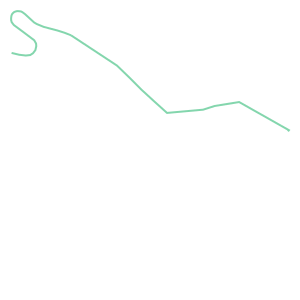

In [125]:

for part in split_parts.geoms:
    if part.length > 0:
        records.append({
            'name': getattr(row, 'name', None),
            'highway': getattr(row, 'highway', None),
            'geometry': part
        })


In [ ]:

    for row in gdf.itertuples(index=False):
        geom = row.geometry

        if prepared_splitters.intersects(geom):
            try:
                split_parts = split(geom, splitters)
                for part in split_parts.geoms:
                    if part.length > 0:
                        records.append({
                            'name': getattr(row, 'name', None),
                            'highway': getattr(row, 'highway', None),
                            'geometry': part
                        })
            except Exception:
                # Fallback in case of split failure
                records.append({
                    'name': getattr(row, 'name', None),
                    'highway': getattr(row, 'highway', None),
                    'geometry': geom
                })
        else:
            records.append({
                'name': getattr(row, 'name', None),
                'highway': getattr(row, 'highway', None),
                'geometry': geom
            })

    temp_geo = gpd.GeoDataFrame(records, crs=gdf.crs)
    temp_geo =temp_geo[temp_geo.length >1e-4]
#     temp_geo['geometry'] = temp_geo['geometry'].apply(
#     lambda geom: LineString([(round(x), round(y)) for x, y in geom.coords])
# )
    return temp_geo


In [ ]:
# Test area - END

In [131]:
# Step 2: Buffer for spatial indexing
mid_result, internal_points= fix_line_topology(gdf_fixed)
mid_result.reset_index().to_file(f'{test_folder}/mid_result.shp')

Extracting intersections: 100%|██████████| 5680/5680 [00:01<00:00, 2845.69it/s]


In [ ]:
## Teat Area - Start

In [114]:
GeoDataFrame(geometry=internal_points, crs=project_crs).to_file(f'{test_folder}/internal_points.shp')

In [582]:

## Teat Area - End

In [95]:
def extract_deadend_points(gdf_edges):
    """
    Identifies all dead-end points (start or end points that appear only once in the entire edge dataset).

    Parameters:
        gdf_edges (GeoDataFrame): Edge lines with LineString geometries.

    Returns:
        Set of Points: All dead-end points.
    """
    endpoint_counter = defaultdict(int)
    def round_point(pt, ndigits=1):
        return tuple(round(c, ndigits) for c in pt)

    for geom in gdf_edges.geometry:
        coords = list(geom.coords)
        endpoint_counter[round_point(coords[0])] += 1
        endpoint_counter[round_point(coords[-1])] += 1

    return endpoint_counter



In [ ]:
# test - start

In [ ]:
# test - End

In [103]:

# preserved_* are sets of shapely Points
preserved_deadends_old = {
    pt for pt, val in extract_deadend_points(first_results).items() if val == 1
}
preserved_deadends_new = {
    pt for pt, val in extract_deadend_points(mid_result).items() if val == 1
}

In [ ]:
# Test  -  Start

In [113]:

points = [Point(x, y) for x, y in preserved_deadends_new]

GeoDataFrame(geometry= points,crs= project_crs).to_file(f'{test_folder}/points.shp')

In [ ]:
# Test -  End

In [110]:

def clean_and_fix_deadends(
        edges_to_fix: gpd.GeoDataFrame,
        preserved_old: set,
        preserved_new: set,
        *,
        buffer_close: float = 20,
        short_cut: float = 50,
        extend_max: float = 150
) -> gpd.GeoDataFrame:
    """
    • Adds columns: start_deadend, end_deadend, has_deadend
    • Drops edges with dead-ends at *both* ends
    • For one-sided dead-ends:
        – If the dead-end is within `buffer_close` of any preserved_old → keep
        – Else, if length < `short_cut` → drop
        – Else → extend until it meets another edge (or nearest edge if none
          within `extend_max`)
    """
    # --- 1. Annotate dead-end status ----------------------------------------
    def _is_deadend(pt):
        return pt in preserved_new
    def round_point(pt, ndigits=2):
        return tuple(round(c, ndigits) for c in pt)

    sindex = edges_to_fix.sindex
    edges_to_fix["start_deadend"] = edges_to_fix.geometry.apply(lambda g: _is_deadend(round_point(g.coords[0])))
    edges_to_fix["end_deadend"]   = edges_to_fix.geometry.apply(lambda g: _is_deadend(round_point(g.coords[-1])))
    edges_to_fix["has_deadend"]   = edges_to_fix["start_deadend"] | edges_to_fix["end_deadend"]

    # Split: rows with / without dead-ends
    keep_rows = edges_to_fix[~edges_to_fix.has_deadend].copy()
    fix_rows  = edges_to_fix[edges_to_fix.has_deadend].copy()
    # ToDo it is just for test
    fix_rows.reset_index().to_file(f'{test_folder}/fix_rows.shp')


    fixed_geoms = []

    for idx, row in tqdm(fix_rows.iterrows(), total=len(fix_rows), desc="Processing edges"):
        geom = row.geometry
        coords = list(geom.coords)
        start_pt, end_pt = Point(coords[0]), Point(coords[-1])
        start_de, end_de = row.start_deadend, row.end_deadend

        # --- 2. Remove if dead-end at both ends -----------------------------
        if start_de and end_de:
            continue  # DROP edge entirely

        # Identify the dead-end & its previous vertex
        if start_de:
            de_pt, prev_pt = start_pt, Point(coords[1])
        else:
            de_pt, prev_pt = end_pt, Point(coords[-2])

        # --- 3. Close to preserved_old? -------------------------------------
        if any(de_pt.distance(Point(old)) < buffer_close for old in preserved_old):
            fixed_geoms.append(row)  # keep as-is
            continue


        # --- 4. Short & isolated? ------------------------------------------
        if geom.length < short_cut:
            continue  # DROP

        # --- 5. Extend ------------------------------------------------------
        new_pt = _extend_to_target(de_pt, prev_pt, edges_to_fix, sindex, idx, max_length=extend_max)
        # Build new LineString
        if start_de:
            new_coords = [(new_pt.x, new_pt.y),*coords]
        else:
            new_coords = [*coords,(new_pt.x, new_pt.y)]
        row['geometry'] = LineString(new_coords)
        fixed_geoms.append(row)

    # Combine kept originals + processed fixes
    gdf_out = GeoDataFrame(fixed_geoms, crs=edges_to_fix.crs)
    return gpd.GeoDataFrame(pd.concat([keep_rows, gdf_out]), crs=project_crs)
def _extend_to_target(pt_deadend: Point,
                      pt_prev: Point,
                      gdf_all: gpd.GeoDataFrame,
                      sindex,
                      cidx,
                      max_length: float = 100):
    """
    Shoot a ray from the dead-end point in the direction of (pt_prev → pt_deadend)
    up to `max_length` and return a new point where it first meets another edge.
    If nothing is hit, return the projection of the dead-end onto the nearest edge.
    """
    # Direction vector (unit)
    vec = np.array(pt_deadend.coords[0]) - np.array(pt_prev.coords[0])
    norm = np.linalg.norm(vec)
    if norm == 0:         # safety
        return pt_deadend
    vec_unit = vec / norm

    ray_end = Point(pt_deadend.x + vec_unit[0] * max_length,
                    pt_deadend.y + vec_unit[1] * max_length)
    ray = LineString([pt_deadend, ray_end])

    # Spatial index for speed
    hits = list(sindex.intersection(ray.bounds))
    candidates0 = gdf_all.iloc[hits]
    candidates = candidates0[candidates0.index != cidx].geometry
    # First intersection (if any)
    intersection_pts = [ray.intersection(g) for g in candidates if ray.intersects(g)]
    intersection_pts = [pt for pt in intersection_pts if not pt.is_empty]

    if intersection_pts:
        # Pick the closest intersection to the dead-end
        dists = [pt_deadend.distance(pt) for pt in intersection_pts]
        return intersection_pts[int(np.argmin(dists))]
    else:
        # Fall-back: project to closest edge (excluding the current ray)
        other_edges = gdf_all.drop(cidx)

        nearest_geom = other_edges.geometry.unary_union
        proj = nearest_points(pt_deadend, nearest_geom)[1]
        return proj



In [ ]:
# test-  start

In [ ]:
# Test - End

In [ ]:
final_result2 = mid_result.copy()
clean_edges = clean_and_fix_deadends(
    final_result2,
    preserved_old=preserved_deadends_old,
    preserved_new=preserved_deadends_new
)
clean_edges.to_file(f'{test_folder}/clean_edges.shp')

In [ ]:
## Test - Start

In [ ]:
## Test - End

In [41]:
# Step 3: Split merged_inter lines by these points
final_result,internal_points= fix_line_topology(clean_edges)
final_result['length'] = final_result.length
final_result.reset_index(drop=True).to_file(f'{data_folder}/network_final2.shp')


Extracting intersections: 100%|██████████| 15354/15354 [00:00<00:00, 18709.82it/s]
